## Description
This code replicates the model discussed in the following research
> A. Chadha, R. Dara and Z. Poljak, "Convolutional Classification of Pathogenicity in H5 Avian Influenza Strains," 2019 18th IEEE International Conference On Machine Learning And Applications (ICMLA), Boca Raton, FL, USA, 2019, pp. 1570-1577.

- Within research 1202 HP sequences, 1167 LP sequences were used which were gathered from various sources such as https://www.fludb.org.  

- This code has yet to collect relevant number of data and works with only 133 HP sequences and 750 LP sequences  
- These sequences were collected from https://www.fludb.org only  
- They are all HA segments of H5 avian influenza virus of various kinds  
- These HA segments are aligned using MUSCLE (Multiple Sequence Comparison by Log-Expectation) algorithm, available [here](https://www.fludb.org/brc/msa.spg?method=ShowCleanInputPage&decorator=influenza)  


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential, utils
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from random import shuffle

In [2]:
# Load data in records, and outputs in y
data = pd.read_csv("./H5.csv")
data = data.iloc[:1800]
records = data["HA"].apply(lambda x: np.array(list(x))).values
y = data["Pathogenicity"].values

print('Highly Pathogenic cases:', np.count_nonzero(y=="HP"))
print('Low Pathogenic cases:', np.count_nonzero(y=="LP"))
print(records.shape)

Highly Pathogenic cases: 938
Low Pathogenic cases: 862
(1800,)


In [3]:
# preprocess input data
sequence = records
le_1 = LabelEncoder()
y = le_1.fit_transform(y) 
y = tf.one_hot(y, 2)

In [4]:
le = LabelEncoder()
seqEncoded = np.zeros((len(records),len(records[0])), dtype=int)
for i, seq in enumerate(sequence):
    seqEncoded[i] = le.fit_transform(seq)

oneHotSeq = tf.one_hot(seqEncoded, depth=21).numpy()

# remove alignment character's one hot
for seq in oneHotSeq:
    for protein in seq:
        if protein[0] == 1:
            protein[0] = 0
print('(samples, proteins, one-hot-encoding) ::',oneHotSeq.shape)

(samples, proteins, one-hot-encoding) :: (1800, 589, 21)


In [5]:
print(oneHotSeq[0][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
trainTestValues=[]
noOfEntries=oneHotSeq.shape[0]
for i in range(noOfEntries):
  itemArray=[oneHotSeq[i],y[i]]
  trainTestValues.append(itemArray)
shuffle(trainTestValues)
testSplitIndex=int(noOfEntries*0.75)
train=trainTestValues[:testSplitIndex]
test=trainTestValues[testSplitIndex:]
X_train=[i[0] for i in train]
X_train=np.array(X_train)
print(X_train[0])
y_train=[i[1] for i in train]
X_test=[i[0] for i in test]
y_test=[i[1] for i in test]
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_train)+len(X_test),noOfEntries)
#X_train,y_train,X_test,y_test = train_test_split(oneHotSeq,y,test_size=0.25)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1350
1350
450
450
1800 1800


In [36]:
# building Model: Sequqntial
model = Sequential()

model.add(Conv1D(20,
                 kernel_size=2,
                 strides=2,
                 activation='relu',
                 input_shape=(oneHotSeq.shape[1], oneHotSeq.shape[2],)))
model.add(MaxPool1D(pool_size=2,
                    strides=2,
                    padding='valid'))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

#building Model: Functional
inp=Input(shape=(oneHotSeq.shape[1], oneHotSeq.shape[2],))

convulational=Conv1D(20,
                     kernel_size=2, 
                     strides=2, 
                     activation='relu')(inp)

Maxpooling=MaxPool1D(pool_size=2, 
                     strides=2, 
                     padding = 'valid')(convulational)

flattening= Flatten()(Maxpooling)

denselayer=Dense(2,
                 activation='softmax')(flattening)

model=Model(inputs=inp, outputs=denslayer)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 294, 20)           860       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 147, 20)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2940)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 5882      
Total params: 6,742
Trainable params: 6,742
Non-trainable params: 0
_________________________________________________________________


In [37]:
# compiling model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [38]:
# training model
# Due to lack of data model is underfitting (training loss >> validation loss)
class_weights = {0: 1.,
                 1: 5}
'''for st in range(100):
  class_weight[1]=2.5+st*0.01
  print(class_weight)
  model.fit(
    np.array(X_train), np.array(y),
    batch_size=32,
    epochs=1,
    validation_split=0.3,
    shuffle=True,
    class_weight=class_weight
    )'''
history = model.fit(
  np.array(X_train), np.array(y_train),
  batch_size=16,
  epochs=100,
  validation_split=0.2,
  shuffle=True,
  class_weight=class_weights
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1080 samples, validate on 270 samples
Epoch 1/100
1080/1080 [==============================] - 1s 998us/sample - loss: 0.7325 - accuracy: 0.7713 - val_loss: 0.3553 - val_accuracy: 0.9259
Epoch 2/100
1080/1080 [==============================] - 0s 268us/sample - loss: 0.2785 - accuracy: 0.9370 - val_loss: 0.2809 - val_accuracy: 0.9259
Epoch 3/100
1080/1080 [==============================] - 0s 293us/sample - loss: 0.2253 - accuracy: 0.9380 - val_loss: 0.2336 - val_accuracy: 0.9259
Epoch 4/100
1080/1080 [==============================] - 0s 268us/sample - loss: 0.1848 - accuracy: 0.9491 - val_loss: 0.2427 - val_accuracy: 0.9333
Epoch 5/100
1080/1080 [==============================] - 0s 283us/sample - loss: 0.1480 - accuracy: 0.9602 - val_loss: 0.1610 - val_accuracy: 0.9481
Epoch 6/100
1080/1080 [==============================] - 0s 291us/sample - loss: 0.1294 - accuracy: 0.9676 - val_loss: 0.1392 - val_accuracy: 0.9630
Epoch 7/1

Epoch 54/100
1080/1080 [==============================] - 0s 315us/sample - loss: 4.6019e-04 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9963
Epoch 55/100
1080/1080 [==============================] - 0s 253us/sample - loss: 4.2151e-04 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9963
Epoch 56/100
1080/1080 [==============================] - 0s 310us/sample - loss: 4.0405e-04 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9963
Epoch 57/100
1080/1080 [==============================] - 0s 278us/sample - loss: 3.7187e-04 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9963
Epoch 58/100
1080/1080 [==============================] - 0s 271us/sample - loss: 3.4402e-04 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.9963
Epoch 59/100
1080/1080 [==============================] - 0s 288us/sample - loss: 3.6931e-04 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 0.9963
Epoch 60/100
1080/1080 [==============================] - 0s 317us/sample - 

In [30]:
y_pred = model.predict(np.array(X_test))
y_pred=y_pred>0.5
print(classification_report(np.array(y_test),y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       209

   micro avg       1.00      1.00      1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450
 samples avg       1.00      1.00      1.00       450



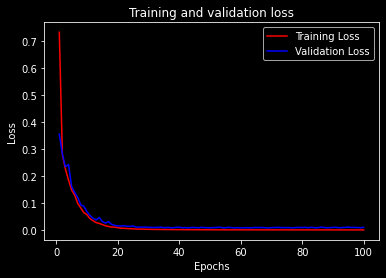

In [39]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.style.use('dark_background')
plt.plot(epochs, loss_train, 'r', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# history.history.keys()

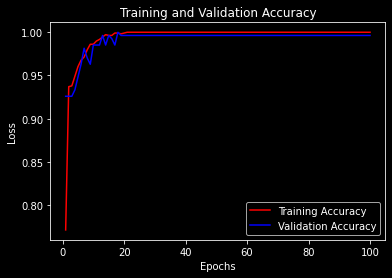

In [40]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs, acc_train, 'r', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ValueError: cannot reshape array of size 1800 into shape (1800,589)